
# RUN VCE - moved to separate script

# PLOT IMGS

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
T = 300
gradscale=500
folder_to_save = f"simple_guidance_class_removing_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
for class_ in ["Cardiomegaly"]:
    x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
    pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
    img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
    pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
    pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
    bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')
print(len(x_samples))

146


IndexError: index 12 is out of bounds for dimension 0 with size 0

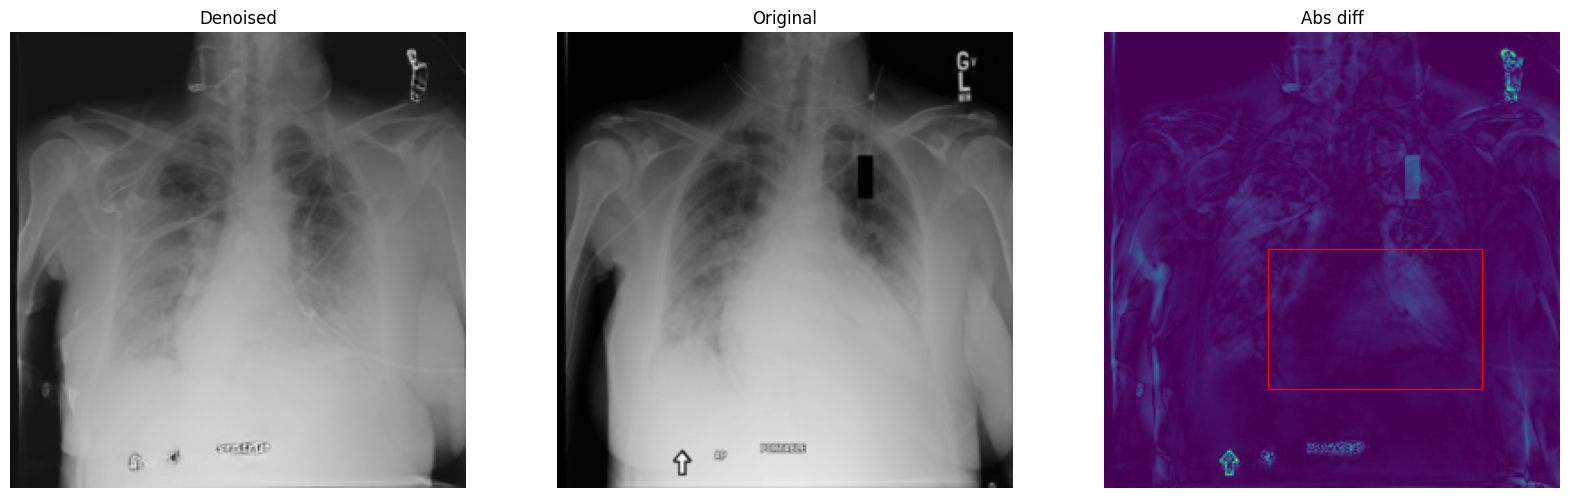

In [3]:
idx_from_batch = 12
fig, axes = plt.subplots(1, 3, figsize=(20, 15))


# Plot the images on the subplots
denoised_guided_normalized = x_samples.cpu()[idx_from_batch].permute(1,2,0)
denoised_guided = denoised_guided_normalized*0.5+0.5
img_ref_normalized = img_original.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_ref_normalized*0.5+0.5
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')
axes[ax].set_title("Denoised")

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')
axes[ax].set_title("Original")

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

if "removing" in folder_to_save:
    # Add the rectangle patch to the plot
    axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')
axes[ax].set_title("Abs diff")


#fig.suptitle(ret[3][0][idx_from_batch])
pred_o_for_item = torch.nn.functional.sigmoid(pred_o[idx_from_batch])
pred_o_ext_for_item = torch.nn.functional.sigmoid(pred_o_ext[idx_from_batch])
pred_ext_for_item = torch.nn.functional.sigmoid(pred_ext[idx_from_batch])
id_class = cl_list.index(class_)
print('all predictins for orig x', pred_o_ext_for_item)
print('all predictins for x pred start', pred_ext_for_item)
print(f'predicitons for x original JOINT, only class {cl_list[id_class]}', pred_o_for_item[id_class])
print(f'predicitons for x original EXT, only class {cl_list[id_class]}', pred_o_ext_for_item[id_class])
print(f'predicitons for x pred start EXT, only class {cl_list[id_class]}',pred_ext_for_item[id_class])



# TABLES

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [5]:
import torch

# Load the full checkpoint
checkpoint = torch.load("/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/chexnet.pth.tar")

# Extract the nested state_dict
original_state_dict = checkpoint['state_dict']

# Create a new state_dict with updated keys
new_state_dict = {}
for key, value in original_state_dict.items():
    
    new_key = key.replace("module.densenet121","densenet121")

    if "norm.weight" not in new_key and "norm.bias" not in new_key and "norm.running" not in new_key:
        new_key = new_key.replace('norm.', 'norm')
    
    if "conv.weight" not in new_key and "conv.bias" not in new_key:
        new_key = new_key.replace("conv.","conv")
    
    new_state_dict[new_key] = value
    

# Update the checkpoint with the modified state_dict
checkpoint['state_dict'] = new_state_dict

# Save the updated checkpoint
torch.save(checkpoint, '/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/chexnet_updated.pth.tar')

# Print a message indicating completion
print("Updated state_dict keys and saved the new checkpoint.")


Updated state_dict keys and saved the new checkpoint.


In [6]:
# initialize and load the model
N_CLASSES = 14
EXT_CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
DATA_DIR = './ChestX-ray14/images'
TEST_IMAGE_LIST = './ChestX-ray14/labels/test_list.txt'
BATCH_SIZE = 64
CKPT_PATH = '/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/chexnet_updated.pth.tar'

model_ext = DenseNet121(N_CLASSES).cuda()
checkpoint = torch.load(CKPT_PATH)
model_ext.load_state_dict(checkpoint['state_dict'])


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [7]:
denoised_guided = x_samples*0.5+0.5
img_ref = img_original*0.5+0.5

In [8]:
import torch
import torchvision.transforms as transforms

# Define the transformations
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize
])

# Function to apply transformations to a tensor
def apply_transformations(tensor):
    transformed_tensors = []
    for img in tensor:
        # Convert grayscale to RGB by repeating the channel
        img_rgb = img.repeat(3, 1, 1).permute(1, 2, 0).numpy()
        img_rgb = (img_rgb*255).astype(np.uint8)
        
        # Apply transformations
        pil_img = transforms.ToPILImage()(img_rgb)
        transformed_tensor = transformations(pil_img)
        
        transformed_tensors.append(transformed_tensor)

    return torch.stack(transformed_tensors)


# Apply transformations to both tensors
transformed_denoised_guided = apply_transformations(denoised_guided)
transformed_img_ref = apply_transformations(img_ref)

# Check the shape of the transformed tensors
print("Transformed denoised_guided shape:", transformed_denoised_guided.shape)
print("Transformed img_ref_normalized shape:", transformed_img_ref.shape)


Transformed denoised_guided shape: torch.Size([146, 3, 224, 224])
Transformed img_ref_normalized shape: torch.Size([146, 3, 224, 224])


In [9]:
model_ext.eval()

output_ref = model_ext(transformed_img_ref.cuda())
output_guided = model_ext(transformed_denoised_guided.cuda())




In [10]:
id_external_model = EXT_CLASS_NAMES.index(class_)
print(class_)
ref_pred=output_ref[:,id_external_model]
guided_pred=output_guided[:,id_external_model]
(ref_pred-guided_pred).mean()

Cardiomegaly


tensor(0.5156, device='cuda:0', grad_fn=<MeanBackward0>)

In [11]:
ref_pred

tensor([0.9959, 0.3737, 0.9955, 0.5350, 0.9880, 0.9449, 0.9852, 0.7179, 0.6497,
        0.9288, 0.6071, 0.2377, 0.9817, 0.4789, 0.9955, 0.9713, 0.9361, 0.8528,
        0.9539, 0.9888, 0.9285, 0.9971, 0.9756, 0.9376, 0.3896, 0.6358, 0.9935,
        0.9197, 0.6854, 0.9607, 0.9120, 0.5399, 0.9847, 0.9007, 0.9123, 0.9808,
        0.9888, 0.1109, 0.8992, 0.7730, 0.8052, 0.2969, 0.8661, 0.6066, 0.2814,
        0.9914, 0.7524, 0.6182, 0.0394, 0.9909, 0.9594, 0.9630, 0.9838, 0.6142,
        0.9370, 0.9843, 0.8656, 0.9378, 0.8924, 0.8245, 0.9404, 0.9647, 0.7149,
        0.9320, 0.9229, 0.6927, 0.9621, 0.8188, 0.7576, 0.9903, 0.8605, 0.9035,
        0.9431, 0.9386, 0.8818, 0.4593, 0.7970, 0.8617, 0.8156, 0.7644, 0.8664,
        0.7758, 0.4395, 0.9876, 0.9486, 0.8985, 0.7876, 0.9618, 0.3534, 0.9502,
        0.8442, 0.8674, 0.9829, 0.8732, 0.8461, 0.9586, 0.5214, 0.9411, 0.9405,
        0.9242, 0.9662, 0.9713, 0.9777, 0.9029, 0.9880, 0.9956, 0.9694, 0.9285,
        0.9823, 0.9718, 0.5833, 0.8147, 

In [12]:
guided_pred

tensor([0.1278, 0.2549, 0.0109, 0.0714, 0.0599, 0.3393, 0.0237, 0.0724, 0.1703,
        0.8865, 0.0205, 0.0836, 0.3170, 0.2811, 0.7370, 0.8338, 0.0467, 0.1327,
        0.2668, 0.3339, 0.0914, 0.8197, 0.8726, 0.0670, 0.8213, 0.2618, 0.5251,
        0.0071, 0.2072, 0.2351, 0.1132, 0.0330, 0.1258, 0.2285, 0.3294, 0.0309,
        0.3331, 0.0175, 0.9165, 0.2556, 0.5976, 0.0958, 0.3912, 0.2630, 0.0161,
        0.0530, 0.2155, 0.0806, 0.0072, 0.3300, 0.6807, 0.4485, 0.1776, 0.1858,
        0.8207, 0.0019, 0.2679, 0.0357, 0.3766, 0.3007, 0.0117, 0.8557, 0.0474,
        0.0653, 0.0607, 0.3711, 0.6315, 0.3002, 0.6008, 0.2778, 0.0995, 0.0885,
        0.2277, 0.6613, 0.1106, 0.1925, 0.0398, 0.6755, 0.5832, 0.4258, 0.0188,
        0.3083, 0.4037, 0.9099, 0.4709, 0.6003, 0.0210, 0.8437, 0.0959, 0.4040,
        0.1368, 0.2960, 0.3537, 0.0254, 0.2673, 0.6329, 0.1785, 0.0977, 0.7506,
        0.0497, 0.9470, 0.9459, 0.8489, 0.0387, 0.1526, 0.0820, 0.0221, 0.4866,
        0.6208, 0.9565, 0.5302, 0.1326, 

In [14]:
import pandas
import torch

In [15]:
T = 200
gradscale=300
folder_to_save = f"simple_guidance_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"


min_prediction_confidence = 0.0
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
indexes = []
data = []
for cl_index, class_ in enumerate(cl_list):
    try:
        x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
        pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
        pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
        bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')
        
        mask = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])>=min_prediction_confidence
        
        diff = ((torch.nn.functional.sigmoid(pred_ext[mask])-(torch.nn.functional.sigmoid(pred_o_ext[mask])))/1).mean(dim=0)
        indexes.append(class_)
        data.append(diff)
    except:
       pass

print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=cl_list, index=indexes)
df= df.applymap(lambda x: x.item())
df.style.highlight_max(color = 'lightgreen', axis = 1) 


Denoising timestep 200, min_prediction_confidence 0.0


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding


In [16]:
pred_o_ext

tensor([])

## Compare predictions only for denoised class

In [ ]:
T = 200
gradscale=300
folder_to_save = f"simple_guidance_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

min_prediction_confidence = 0.0
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
folder_to_save='vce_scale0'
indexes = []
data = []
for cl_index, class_ in enumerate(cl_list):
    try:
        x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
        pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
        pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
        bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')
        
        mask = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])>=min_prediction_confidence
        pred_o_ext_class = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])[mask].mean()
        pred_ext_class = torch.nn.functional.sigmoid(pred_ext[:, cl_index])[mask].mean()
        
        diff = (pred_ext_class-pred_o_ext_class)
        diff_perc = ((pred_ext_class-pred_o_ext_class)/pred_o_ext_class)*100
        n_samples = mask.sum()
        indexes.append(class_)
        data.append([pred_o_ext_class, pred_ext_class, diff, diff_perc, n_samples])
    except:
        pass

print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=["mean_orig_pred", "mean_denoised_pred","abs diff", "perc diff", "n_samples"], index=indexes)
df= df.applymap(lambda x: x.item())
df#.style.highlight_min(color = 'lightgreen', axis = 0) 

Denoising timestep 200, min_prediction_confidence 0.0


,mean_orig_pred,mean_denoised_pred,abs diff,perc diff,n_samples
